<a href="https://colab.research.google.com/github/ecruz0369/DA6233ECruz--2023/blob/main/IS6733kml614_WineLab1(actual).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Neural Network to Predict Quality of Wine
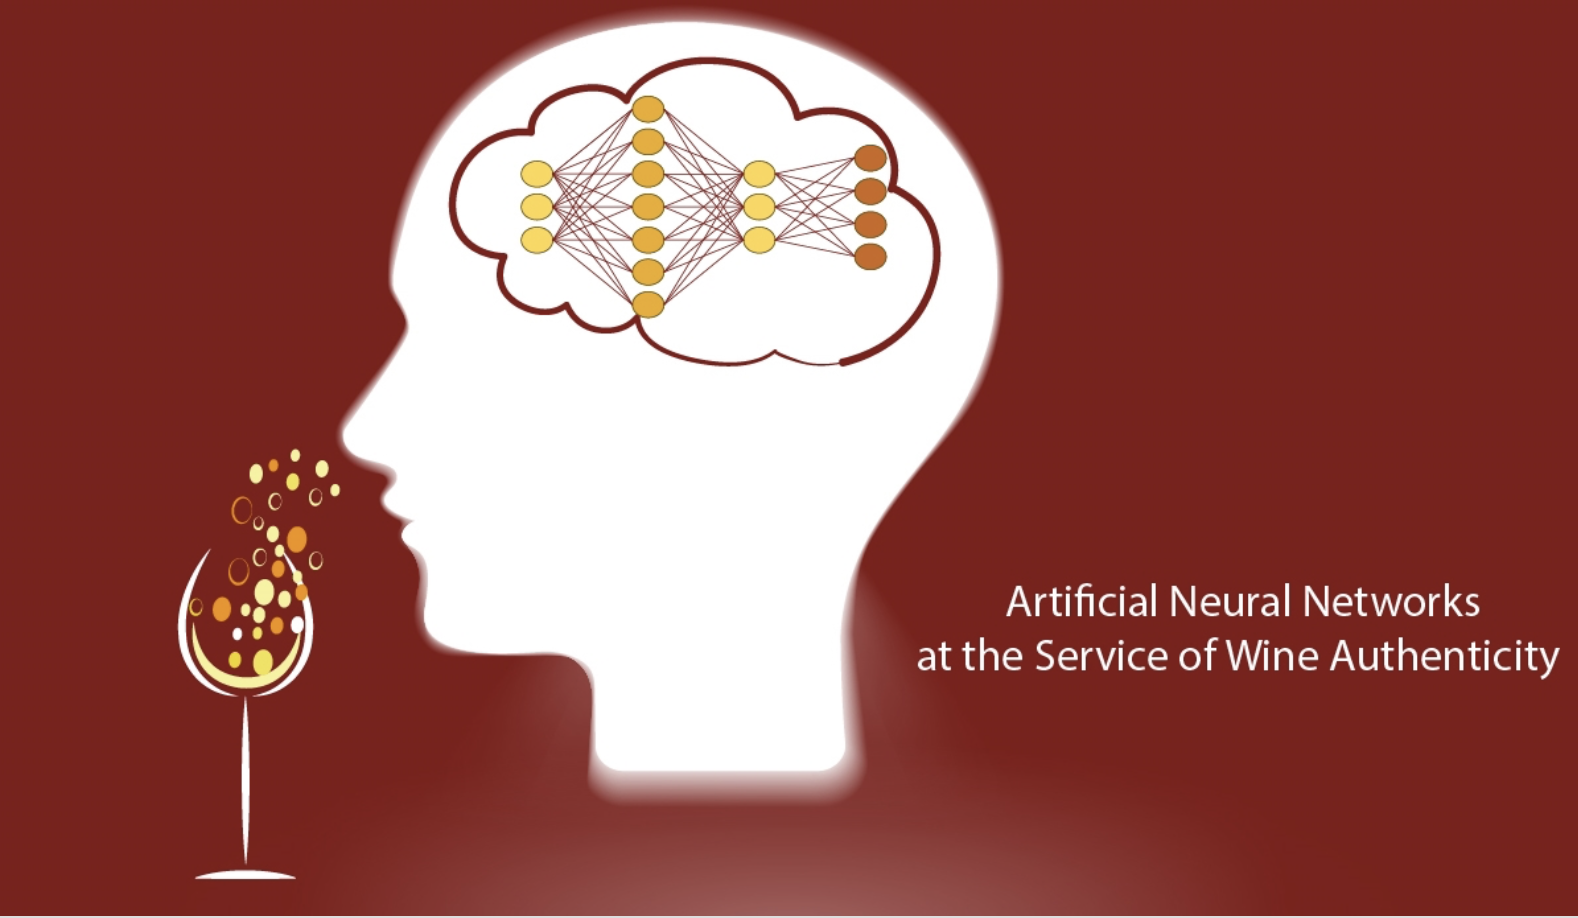
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Dataset

In [13]:
data_df = pd.read_csv("/content/sample_data/winequality-red.csv")

In [14]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [15]:
# how many features?
len(data_df.columns) - 1

11

In [16]:
print(data_df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [17]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [18]:
# convert these quaity measures to labels (0 to 5)
def get_label(quality):
    if quality == 3:
        return 0
    elif quality == 4:
        return 1
    elif quality == 5:
        return 2
    elif quality == 6:
        return 3
    elif quality == 7:
        return 4
    else:
        return 5

labels = data_df['quality'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [19]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   
1      -0.298454          1.966827    -1.391037        0.043403   0.223805   
2      -0.298454          1.296660    -1.185699       -0.169374   0.096323   
3       1.654339         -1.384011     1.483689       -0.453077  -0.264878   
4      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466047             -0.379014  0.558100  1.288240  -0.579025   
1             0.872365              0.624168  0.028252 -0.719708   0.128910   
2            -0.083643              0.228975  0.134222 -0.331073  -0.048074   
3             0.107558              0.411372  0.664069 -0.978798  -0.461036   
4            -0.466047             -0.379014  0.558100  1.288240  -0.579025   

    alcohol   quality  label  
0 -0.959946 -0.787576      2  
1 -0.584594 -0.787576      2  
2 -0.584594 -0.787576      2  
3 -0.584594  0.450707      3  
4 -0.959946 -0.787576      2

In [20]:
# sumamry statistics of the data
data_df.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.599000e+03      1.599000e+03  1.599000e+03    1.599000e+03   
mean    3.554936e-16      1.688594e-16 -1.066481e-16   -1.110917e-16   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.136377e+00     -2.277567e+00 -1.391037e+00   -1.162333e+00   
25%    -7.004996e-01     -7.696903e-01 -9.290275e-01   -4.530767e-01   
50%    -2.410190e-01     -4.367545e-02 -5.634264e-02   -2.402999e-01   
75%     5.056370e-01      6.264921e-01  7.650078e-01    4.340257e-02   
max     4.353787e+00      5.876138e+00  3.742403e+00    9.192806e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.599000e+03         1.599000e+03          1.599000e+03  1.599000e+03   
mean   2.132961e-16        -6.221137e-17          2.666202e-17 -3.469617e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.603443e+00        -1.422055e+00         -1.230199e+00 -3.537625e+00   
25%   -3.711129e-01        -8.484502e-01         -7.438076e-01 -6.075656e-01   
50%   -1.798892e-01        -1.792441e-01         -2.574163e-01  1.759533e-03   
75%    5.382858e-02         4.899619e-01          4.721707e-01  5.766445e-01   
max    1.112355e+01         5.365606e+00          7.372847e+00  3.678904e+00   

                 pH     sulphates       alcohol       quality        label  
count  1.599000e+03  1.599000e+03  1.599000e+03  1.599000e+03  1599.000000  
mean   2.861723e-15  6.665504e-16  7.109871e-17  6.221137e-17     2.636023  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00     0.807569  
min   -3.699244e+00 -1.935902e+00 -1.898325e+00 -3.264143e+00     0.000000  
25%   -6.549356e-01 -6.380200e-01 -8.661079e-01 -7.875763e-01     2.000000  
50%   -7.210449e-03 -2.250577e-01 -2.092427e-01  4.507074e-01     3.000000  
75%    5.757422e-01  4.238832e-01  6.352984e-01  4.507074e-01     3.000000  
max    4.526866e+00  7.916200e+00  4.201138e+00  2.927275e+00     5.000000

## Load this dataset for training a neural network

In [21]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['fixed acidity'], i['volatile acidity'], i['citric acid'], i['residual sugar'], i['chlorides'], i['free sulfur dioxide'], i['total sulfur dioxide'], i['density'], i['pH'], i['sulphates'], i['alcohol']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [22]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(2), 'features': tensor([-0.5282,  0.9616, -1.3910, -0.4531, -0.2436, -0.4660, -0.3790,  0.5581,
         1.2882, -0.5790, -0.9599])}


## Neural Network

In [23]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x) #non-linear function
        x = self.linear2(x)
        x = self.softmax(x)  #sigmoid - softmax function
        return x

winemodel = WineModel().to(device)

## Training

In [27]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #MSE
optimizer = AdamW(winemodel.parameters(), lr = 1e-3) #gradient descent adjust this

In [28]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs) #forward pass

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels) #compute the error
    acc = accuracy(outputs, labels)

    loss.backward()  # compute the weight updates Delta Ji
    optimizer.step()  #do weight update
    optimizer.zero_grad()  #clear it out the weights for the next iteration

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [29]:
# Let's train our model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.536 | Train Acc: 53.12% | Val. Loss: 1.430 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.464 | Train Acc: 57.97% | Val. Loss: 1.412 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.446 | Train Acc: 60.23% | Val. Loss: 1.403 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.434 | Train Acc: 61.64% | Val. Loss: 1.403 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.425 | Train Acc: 62.03% | Val. Loss: 1.388 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.420 | Train Acc: 62.73% | Val. Loss: 1.387 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.416 | Train Acc: 63.44% | Val. Loss: 1.386 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.412 | Train Acc: 64.06% | Val. Loss: 1.381 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.408 | Train Acc: 64.06% | Val. Loss: 1.380 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.405 | Train Acc: 64.22% | Val. Loss: 1.380 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.403 | Train Acc: 64.53% | Val. Loss: 1.379 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.398 | Train Acc: 65.39% | Val. Loss: 1.383 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.398 | Train Acc: 64.61% | Val. Loss: 1.377 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.393 | Train Acc: 66.56% | Val. Loss: 1.380 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.392 | Train Acc: 66.25% | Val. Loss: 1.371 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.390 | Train Acc: 66.02% | Val. Loss: 1.380 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.387 | Train Acc: 66.88% | Val. Loss: 1.367 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.385 | Train Acc: 66.64% | Val. Loss: 1.361 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.384 | Train Acc: 66.80% | Val. Loss: 1.365 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.382 | Train Acc: 67.11% | Val. Loss: 1.368 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.379 | Train Acc: 67.34% | Val. Loss: 1.369 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.378 | Train Acc: 67.73% | Val. Loss: 1.361 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.374 | Train Acc: 67.81% | Val. Loss: 1.353 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.374 | Train Acc: 67.97% | Val. Loss: 1.356 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.371 | Train Acc: 68.44% | Val. Loss: 1.353 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.371 | Train Acc: 68.59% | Val. Loss: 1.353 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.368 | Train Acc: 68.83% | Val. Loss: 1.349 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.366 | Train Acc: 69.22% | Val. Loss: 1.351 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.364 | Train Acc: 69.38% | Val. Loss: 1.344 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.364 | Train Acc: 69.14% | Val. Loss: 1.357 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.364 | Train Acc: 68.91% | Val. Loss: 1.347 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.360 | Train Acc: 69.77% | Val. Loss: 1.356 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.360 | Train Acc: 70.31% | Val. Loss: 1.351 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.358 | Train Acc: 69.92% | Val. Loss: 1.353 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.358 | Train Acc: 69.38% | Val. Loss: 1.345 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.357 | Train Acc: 69.77% | Val. Loss: 1.349 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.355 | Train Acc: 70.16% | Val. Loss: 1.353 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.355 | Train Acc: 70.08% | Val. Loss: 1.338 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.353 | Train Acc: 70.00% | Val. Loss: 1.343 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.353 | Train Acc: 70.31% | Val. Loss: 1.345 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.354 | Train Acc: 69.84% | Val. Loss: 1.344 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.353 | Train Acc: 70.08% | Val. Loss: 1.354 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.350 | Train Acc: 70.39% | Val. Loss: 1.346 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.350 | Train Acc: 70.00% | Val. Loss: 1.342 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.349 | Train Acc: 70.94% | Val. Loss: 1.342 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.350 | Train Acc: 70.39% | Val. Loss: 1.341 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.348 | Train Acc: 70.55% | Val. Loss: 1.347 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.344 | Train Acc: 70.86% | Val. Loss: 1.346 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.344 | Train Acc: 71.09% | Val. Loss: 1.349 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.347 | Train Acc: 70.55% | Val. Loss: 1.341 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.347 | Train Acc: 70.62% | Val. Loss: 1.339 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.344 | Train Acc: 71.02% | Val. Loss: 1.338 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.342 | Train Acc: 71.25% | Val. Loss: 1.347 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.342 | Train Acc: 71.25% | Val. Loss: 1.335 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.339 | Train Acc: 71.41% | Val. Loss: 1.337 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.339 | Train Acc: 71.80% | Val. Loss: 1.341 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.339 | Train Acc: 71.56% | Val. Loss: 1.345 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.339 | Train Acc: 71.56% | Val. Loss: 1.340 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.337 | Train Acc: 71.88% | Val. Loss: 1.345 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.334 | Train Acc: 72.27% | Val. Loss: 1.333 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.335 | Train Acc: 71.72% | Val. Loss: 1.332 | Val. Acc: 73.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.333 | Train Acc: 72.27% | Val. Loss: 1.343 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.333 | Train Acc: 72.42% | Val. Loss: 1.342 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.334 | Train Acc: 72.34% | Val. Loss: 1.350 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.333 | Train Acc: 72.19% | Val. Loss: 1.334 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.330 | Train Acc: 72.81% | Val. Loss: 1.339 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.332 | Train Acc: 72.50% | Val. Loss: 1.342 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.329 | Train Acc: 73.12% | Val. Loss: 1.331 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.331 | Train Acc: 72.58% | Val. Loss: 1.349 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.328 | Train Acc: 72.50% | Val. Loss: 1.338 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.327 | Train Acc: 73.12% | Val. Loss: 1.342 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.327 | Train Acc: 73.05% | Val. Loss: 1.347 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.328 | Train Acc: 72.81% | Val. Loss: 1.344 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.325 | Train Acc: 73.12% | Val. Loss: 1.341 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.327 | Train Acc: 72.89% | Val. Loss: 1.340 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.325 | Train Acc: 73.28% | Val. Loss: 1.348 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.325 | Train Acc: 73.28% | Val. Loss: 1.343 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.322 | Train Acc: 73.52% | Val. Loss: 1.348 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.324 | Train Acc: 72.89% | Val. Loss: 1.350 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.321 | Train Acc: 73.44% | Val. Loss: 1.355 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.322 | Train Acc: 73.12% | Val. Loss: 1.350 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.322 | Train Acc: 73.28% | Val. Loss: 1.350 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.323 | Train Acc: 73.28% | Val. Loss: 1.336 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.320 | Train Acc: 73.28% | Val. Loss: 1.341 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.322 | Train Acc: 73.28% | Val. Loss: 1.344 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.318 | Train Acc: 73.91% | Val. Loss: 1.334 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.319 | Train Acc: 73.59% | Val. Loss: 1.343 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.318 | Train Acc: 73.59% | Val. Loss: 1.338 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.317 | Train Acc: 73.44% | Val. Loss: 1.339 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.319 | Train Acc: 73.59% | Val. Loss: 1.328 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.316 | Train Acc: 73.75% | Val. Loss: 1.338 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.317 | Train Acc: 73.75% | Val. Loss: 1.343 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.316 | Train Acc: 73.98% | Val. Loss: 1.341 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.314 | Train Acc: 74.30% | Val. Loss: 1.345 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.316 | Train Acc: 73.67% | Val. Loss: 1.342 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.314 | Train Acc: 73.98% | Val. Loss: 1.350 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.312 | Train Acc: 74.45% | Val. Loss: 1.344 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.311 | Train Acc: 74.38% | Val. Loss: 1.338 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.313 | Train Acc: 74.14% | Val. Loss: 1.340 | Val. Acc: 72.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.312 | Train Acc: 74.38% | Val. Loss: 1.341 | Val. Acc: 71.88% |


# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)

In [30]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')


| Test Loss: 1.378 | Test Acc: 66.25% |


## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

In [31]:
# Increase the number of epochs
num_epochs = 150  # Example: change from 100 to 150
optimizer = AdamW(winemodel.parameters(), lr=2e-3)  # Example: slightly increase learning rate

# Train the model for more epochs
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*150:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*150:.2f}% |')

# Finally, evaluate on test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.320 | Train Acc: 109.80% | Val. Loss: 1.343 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.321 | Train Acc: 109.69% | Val. Loss: 1.365 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.321 | Train Acc: 109.57% | Val. Loss: 1.359 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.320 | Train Acc: 109.69% | Val. Loss: 1.343 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.323 | Train Acc: 108.87% | Val. Loss: 1.357 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.313 | Train Acc: 111.21% | Val. Loss: 1.334 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.316 | Train Acc: 110.62% | Val. Loss: 1.358 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.316 | Train Acc: 109.92% | Val. Loss: 1.362 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.318 | Train Acc: 109.80% | Val. Loss: 1.359 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.320 | Train Acc: 109.57% | Val. Loss: 1.347 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.314 | Train Acc: 110.39% | Val. Loss: 1.357 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.310 | Train Acc: 111.45% | Val. Loss: 1.341 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.311 | Train Acc: 111.09% | Val. Loss: 1.370 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.320 | Train Acc: 110.16% | Val. Loss: 1.372 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.316 | Train Acc: 109.80% | Val. Loss: 1.358 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.312 | Train Acc: 111.33% | Val. Loss: 1.372 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.314 | Train Acc: 110.27% | Val. Loss: 1.347 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.308 | Train Acc: 111.45% | Val. Loss: 1.375 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.314 | Train Acc: 110.51% | Val. Loss: 1.337 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.311 | Train Acc: 110.74% | Val. Loss: 1.355 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.314 | Train Acc: 110.74% | Val. Loss: 1.342 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.312 | Train Acc: 110.62% | Val. Loss: 1.360 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.310 | Train Acc: 111.09% | Val. Loss: 1.359 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.314 | Train Acc: 110.62% | Val. Loss: 1.354 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.311 | Train Acc: 110.74% | Val. Loss: 1.357 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.307 | Train Acc: 111.33% | Val. Loss: 1.361 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.308 | Train Acc: 111.21% | Val. Loss: 1.368 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.306 | Train Acc: 112.03% | Val. Loss: 1.348 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.306 | Train Acc: 111.68% | Val. Loss: 1.346 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.305 | Train Acc: 111.80% | Val. Loss: 1.351 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.310 | Train Acc: 110.74% | Val. Loss: 1.341 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.305 | Train Acc: 111.80% | Val. Loss: 1.351 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.315 | Train Acc: 110.27% | Val. Loss: 1.375 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.302 | Train Acc: 112.62% | Val. Loss: 1.378 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.310 | Train Acc: 111.21% | Val. Loss: 1.362 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.309 | Train Acc: 110.98% | Val. Loss: 1.339 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.307 | Train Acc: 111.80% | Val. Loss: 1.383 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.304 | Train Acc: 112.38% | Val. Loss: 1.368 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.310 | Train Acc: 111.33% | Val. Loss: 1.346 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.298 | Train Acc: 112.97% | Val. Loss: 1.342 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.305 | Train Acc: 112.15% | Val. Loss: 1.358 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.302 | Train Acc: 112.03% | Val. Loss: 1.371 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.301 | Train Acc: 112.62% | Val. Loss: 1.362 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.305 | Train Acc: 111.91% | Val. Loss: 1.357 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.303 | Train Acc: 111.91% | Val. Loss: 1.354 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.309 | Train Acc: 110.98% | Val. Loss: 1.363 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.300 | Train Acc: 112.97% | Val. Loss: 1.352 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.306 | Train Acc: 111.45% | Val. Loss: 1.374 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.305 | Train Acc: 111.80% | Val. Loss: 1.374 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.302 | Train Acc: 112.85% | Val. Loss: 1.350 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.296 | Train Acc: 112.97% | Val. Loss: 1.362 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.300 | Train Acc: 112.15% | Val. Loss: 1.358 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.297 | Train Acc: 113.20% | Val. Loss: 1.343 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.302 | Train Acc: 112.38% | Val. Loss: 1.365 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.296 | Train Acc: 112.97% | Val. Loss: 1.366 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.300 | Train Acc: 112.03% | Val. Loss: 1.341 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.300 | Train Acc: 112.38% | Val. Loss: 1.378 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.300 | Train Acc: 112.50% | Val. Loss: 1.362 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.300 | Train Acc: 112.97% | Val. Loss: 1.363 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.301 | Train Acc: 112.73% | Val. Loss: 1.340 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.307 | Train Acc: 111.80% | Val. Loss: 1.344 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.292 | Train Acc: 114.02% | Val. Loss: 1.364 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.295 | Train Acc: 113.44% | Val. Loss: 1.350 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.294 | Train Acc: 113.44% | Val. Loss: 1.343 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.294 | Train Acc: 113.55% | Val. Loss: 1.346 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.296 | Train Acc: 113.20% | Val. Loss: 1.373 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.301 | Train Acc: 113.09% | Val. Loss: 1.365 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.297 | Train Acc: 112.62% | Val. Loss: 1.355 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.294 | Train Acc: 113.09% | Val. Loss: 1.362 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.289 | Train Acc: 114.38% | Val. Loss: 1.375 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.303 | Train Acc: 111.21% | Val. Loss: 1.386 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.291 | Train Acc: 113.91% | Val. Loss: 1.366 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.298 | Train Acc: 112.27% | Val. Loss: 1.377 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.295 | Train Acc: 113.09% | Val. Loss: 1.353 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.295 | Train Acc: 113.20% | Val. Loss: 1.362 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.291 | Train Acc: 113.79% | Val. Loss: 1.359 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.291 | Train Acc: 113.67% | Val. Loss: 1.370 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.300 | Train Acc: 112.27% | Val. Loss: 1.365 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.296 | Train Acc: 112.73% | Val. Loss: 1.386 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.295 | Train Acc: 112.85% | Val. Loss: 1.355 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.288 | Train Acc: 114.14% | Val. Loss: 1.385 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.293 | Train Acc: 113.09% | Val. Loss: 1.383 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.293 | Train Acc: 113.32% | Val. Loss: 1.356 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.291 | Train Acc: 113.44% | Val. Loss: 1.345 | Val. Acc: 108.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.296 | Train Acc: 113.32% | Val. Loss: 1.356 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.291 | Train Acc: 114.26% | Val. Loss: 1.332 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.295 | Train Acc: 112.97% | Val. Loss: 1.361 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.291 | Train Acc: 113.91% | Val. Loss: 1.364 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.289 | Train Acc: 113.79% | Val. Loss: 1.365 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.292 | Train Acc: 113.20% | Val. Loss: 1.377 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.288 | Train Acc: 114.49% | Val. Loss: 1.358 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.290 | Train Acc: 114.49% | Val. Loss: 1.361 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.292 | Train Acc: 113.32% | Val. Loss: 1.361 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.284 | Train Acc: 115.20% | Val. Loss: 1.354 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.285 | Train Acc: 114.96% | Val. Loss: 1.371 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.287 | Train Acc: 114.49% | Val. Loss: 1.379 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.287 | Train Acc: 114.49% | Val. Loss: 1.354 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.287 | Train Acc: 114.96% | Val. Loss: 1.365 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.281 | Train Acc: 115.31% | Val. Loss: 1.357 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.282 | Train Acc: 114.84% | Val. Loss: 1.371 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 1.280 | Train Acc: 115.78% | Val. Loss: 1.361 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 1.283 | Train Acc: 115.31% | Val. Loss: 1.365 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 1.287 | Train Acc: 115.08% | Val. Loss: 1.385 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 1.280 | Train Acc: 115.66% | Val. Loss: 1.362 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 1.283 | Train Acc: 115.55% | Val. Loss: 1.398 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 1.283 | Train Acc: 115.43% | Val. Loss: 1.361 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 1.284 | Train Acc: 115.20% | Val. Loss: 1.373 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 1.282 | Train Acc: 115.31% | Val. Loss: 1.341 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 1.284 | Train Acc: 114.73% | Val. Loss: 1.346 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 1.282 | Train Acc: 114.96% | Val. Loss: 1.361 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 1.276 | Train Acc: 115.90% | Val. Loss: 1.357 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 1.279 | Train Acc: 115.55% | Val. Loss: 1.381 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 1.286 | Train Acc: 114.38% | Val. Loss: 1.387 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 1.274 | Train Acc: 116.95% | Val. Loss: 1.353 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 1.291 | Train Acc: 114.14% | Val. Loss: 1.354 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 1.281 | Train Acc: 115.90% | Val. Loss: 1.342 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 1.288 | Train Acc: 114.38% | Val. Loss: 1.360 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 1.277 | Train Acc: 116.60% | Val. Loss: 1.351 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 1.277 | Train Acc: 116.37% | Val. Loss: 1.357 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 1.277 | Train Acc: 116.37% | Val. Loss: 1.353 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 1.274 | Train Acc: 116.37% | Val. Loss: 1.362 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 1.277 | Train Acc: 115.90% | Val. Loss: 1.346 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 1.277 | Train Acc: 116.37% | Val. Loss: 1.361 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 1.275 | Train Acc: 116.25% | Val. Loss: 1.347 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 1.272 | Train Acc: 116.84% | Val. Loss: 1.351 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 1.275 | Train Acc: 116.25% | Val. Loss: 1.362 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 1.277 | Train Acc: 115.90% | Val. Loss: 1.348 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 1.277 | Train Acc: 116.02% | Val. Loss: 1.352 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 1.273 | Train Acc: 116.95% | Val. Loss: 1.347 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 1.272 | Train Acc: 116.60% | Val. Loss: 1.360 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 1.281 | Train Acc: 115.78% | Val. Loss: 1.356 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 1.275 | Train Acc: 116.25% | Val. Loss: 1.372 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 1.279 | Train Acc: 115.78% | Val. Loss: 1.337 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 1.275 | Train Acc: 116.48% | Val. Loss: 1.329 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 1.272 | Train Acc: 116.48% | Val. Loss: 1.353 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 1.298 | Train Acc: 112.73% | Val. Loss: 1.379 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 1.286 | Train Acc: 115.08% | Val. Loss: 1.354 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 1.285 | Train Acc: 114.96% | Val. Loss: 1.376 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 1.276 | Train Acc: 116.72% | Val. Loss: 1.363 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 1.272 | Train Acc: 116.95% | Val. Loss: 1.357 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 1.270 | Train Acc: 117.19% | Val. Loss: 1.358 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 1.268 | Train Acc: 117.42% | Val. Loss: 1.385 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 1.273 | Train Acc: 116.60% | Val. Loss: 1.354 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 1.268 | Train Acc: 118.01% | Val. Loss: 1.352 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 1.267 | Train Acc: 117.54% | Val. Loss: 1.373 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 1.273 | Train Acc: 116.72% | Val. Loss: 1.359 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 1.270 | Train Acc: 117.30% | Val. Loss: 1.365 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 1.269 | Train Acc: 117.30% | Val. Loss: 1.357 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 1.274 | Train Acc: 116.84% | Val. Loss: 1.357 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 1.273 | Train Acc: 116.48% | Val. Loss: 1.356 | Val. Acc: 103.12% |
| Test Loss: 1.372 | Test Acc: 101.56% |


In [32]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

| Test Loss: 1.372 | Test Acc: 101.56% |


## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

In [33]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
######### Demo do not use#######
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear_another_hidden = torch.nn.Linear(200, 300) #another layer
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x) #11,200
        x = self.activation(x) #non-linear function
        x = self.linear3(x) #200,200
        x = self.activation(x)
        x = self.linear2(x) #200,6
        x = self.softmax(x)  #sigmoid - softmax function
        return x

winemodel = WineModel().to(device)

In [35]:
import torch

class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        # Updated layer widths
        self.linear1 = torch.nn.Linear(11, 400)  # Changed from 200 to 400 neurons
        self.activation = torch.nn.ReLU()
        self.linear_another_hidden = torch.nn.Linear(400, 600)  # Changed from 300 to 600 neurons
        self.linear2 = torch.nn.Linear(600, 6)  # Final output remains unchanged
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)  # Input to the first layer (11 features -> 400 neurons)
        x = self.activation(x)  # ReLU activation
        x = self.linear_another_hidden(x)  # Hidden layer (400 neurons -> 600 neurons)
        x = self.activation(x)  # ReLU activation
        x = self.linear2(x)  # Final output layer (600 neurons -> 6 classes)
        x = self.softmax(x)  # Softmax activation for classification
        return x

# Moving the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
winemodel = WineModel().to(device)

## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

In [36]:
# Initialize the updated model and move it to the device (GPU if available)
winemodel = WineModel().to(device)

# Define the loss function and optimizer (same as before)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr=1e-3)

# Train the model
for epoch in range(100):  # Fixed syntax
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*200:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*200:.2f}% |')

# Evaluate the model on the test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test. Loss: {test_loss:.3f} | Test. Acc: {test_acc*200:.2f}% |')



  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.488 | Train Acc: 112.50% | Val. Loss: 1.424 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.467 | Train Acc: 114.22% | Val. Loss: 1.418 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.456 | Train Acc: 117.03% | Val. Loss: 1.422 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.457 | Train Acc: 117.19% | Val. Loss: 1.413 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.439 | Train Acc: 120.47% | Val. Loss: 1.413 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.450 | Train Acc: 118.75% | Val. Loss: 1.419 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.450 | Train Acc: 118.44% | Val. Loss: 1.417 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.466 | Train Acc: 115.16% | Val. Loss: 1.433 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.453 | Train Acc: 118.12% | Val. Loss: 1.415 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.458 | Train Acc: 116.56% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.449 | Train Acc: 118.44% | Val. Loss: 1.408 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.433 | Train Acc: 121.72% | Val. Loss: 1.399 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.442 | Train Acc: 119.84% | Val. Loss: 1.404 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.435 | Train Acc: 121.09% | Val. Loss: 1.405 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.432 | Train Acc: 122.03% | Val. Loss: 1.390 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.437 | Train Acc: 120.94% | Val. Loss: 1.411 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.439 | Train Acc: 120.62% | Val. Loss: 1.392 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.430 | Train Acc: 122.66% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.436 | Train Acc: 121.41% | Val. Loss: 1.391 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.430 | Train Acc: 122.19% | Val. Loss: 1.430 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.435 | Train Acc: 121.56% | Val. Loss: 1.399 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.425 | Train Acc: 123.44% | Val. Loss: 1.365 | Val. Acc: 136.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.417 | Train Acc: 125.00% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.427 | Train Acc: 122.97% | Val. Loss: 1.427 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.434 | Train Acc: 121.88% | Val. Loss: 1.385 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.418 | Train Acc: 125.00% | Val. Loss: 1.372 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.437 | Train Acc: 120.94% | Val. Loss: 1.391 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.421 | Train Acc: 124.53% | Val. Loss: 1.395 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.418 | Train Acc: 125.00% | Val. Loss: 1.407 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.416 | Train Acc: 125.16% | Val. Loss: 1.382 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.425 | Train Acc: 124.06% | Val. Loss: 1.373 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.416 | Train Acc: 125.31% | Val. Loss: 1.375 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.432 | Train Acc: 122.19% | Val. Loss: 1.399 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.416 | Train Acc: 125.16% | Val. Loss: 1.371 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.419 | Train Acc: 124.84% | Val. Loss: 1.373 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.424 | Train Acc: 123.91% | Val. Loss: 1.406 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.417 | Train Acc: 125.16% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.413 | Train Acc: 126.25% | Val. Loss: 1.397 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.414 | Train Acc: 125.63% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.414 | Train Acc: 125.78% | Val. Loss: 1.387 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.415 | Train Acc: 125.47% | Val. Loss: 1.408 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.412 | Train Acc: 126.09% | Val. Loss: 1.391 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.410 | Train Acc: 126.56% | Val. Loss: 1.391 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.408 | Train Acc: 126.88% | Val. Loss: 1.375 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.410 | Train Acc: 126.72% | Val. Loss: 1.410 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.417 | Train Acc: 125.47% | Val. Loss: 1.374 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.409 | Train Acc: 127.19% | Val. Loss: 1.393 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.414 | Train Acc: 126.09% | Val. Loss: 1.404 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.416 | Train Acc: 125.16% | Val. Loss: 1.390 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.411 | Train Acc: 126.72% | Val. Loss: 1.398 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.407 | Train Acc: 127.50% | Val. Loss: 1.407 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.405 | Train Acc: 127.66% | Val. Loss: 1.389 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.403 | Train Acc: 127.97% | Val. Loss: 1.385 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.400 | Train Acc: 128.59% | Val. Loss: 1.382 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.397 | Train Acc: 129.38% | Val. Loss: 1.386 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.403 | Train Acc: 127.97% | Val. Loss: 1.383 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.404 | Train Acc: 127.81% | Val. Loss: 1.387 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.400 | Train Acc: 128.75% | Val. Loss: 1.406 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.404 | Train Acc: 127.81% | Val. Loss: 1.407 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.407 | Train Acc: 127.50% | Val. Loss: 1.404 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.398 | Train Acc: 128.91% | Val. Loss: 1.377 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.405 | Train Acc: 127.66% | Val. Loss: 1.407 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.411 | Train Acc: 126.56% | Val. Loss: 1.414 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.400 | Train Acc: 128.59% | Val. Loss: 1.402 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.403 | Train Acc: 128.12% | Val. Loss: 1.391 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.404 | Train Acc: 127.97% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.399 | Train Acc: 129.06% | Val. Loss: 1.386 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.398 | Train Acc: 129.06% | Val. Loss: 1.400 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.395 | Train Acc: 129.84% | Val. Loss: 1.392 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.391 | Train Acc: 130.47% | Val. Loss: 1.392 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.391 | Train Acc: 130.47% | Val. Loss: 1.387 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.410 | Train Acc: 126.72% | Val. Loss: 1.432 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.431 | Train Acc: 122.03% | Val. Loss: 1.417 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.412 | Train Acc: 126.09% | Val. Loss: 1.437 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.438 | Train Acc: 121.09% | Val. Loss: 1.391 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.410 | Train Acc: 126.25% | Val. Loss: 1.413 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.404 | Train Acc: 127.50% | Val. Loss: 1.369 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.394 | Train Acc: 129.69% | Val. Loss: 1.392 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.400 | Train Acc: 128.75% | Val. Loss: 1.402 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.377 | Train Acc: 133.28% | Val. Loss: 1.383 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.376 | Train Acc: 134.06% | Val. Loss: 1.386 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.377 | Train Acc: 133.12% | Val. Loss: 1.436 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.368 | Train Acc: 134.69% | Val. Loss: 1.390 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.361 | Train Acc: 136.41% | Val. Loss: 1.381 | Val. Acc: 132.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.359 | Train Acc: 136.88% | Val. Loss: 1.406 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.377 | Train Acc: 133.12% | Val. Loss: 1.388 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.372 | Train Acc: 134.53% | Val. Loss: 1.375 | Val. Acc: 133.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.371 | Train Acc: 134.22% | Val. Loss: 1.412 | Val. Acc: 127.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.395 | Train Acc: 129.22% | Val. Loss: 1.415 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.383 | Train Acc: 132.19% | Val. Loss: 1.421 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.365 | Train Acc: 135.47% | Val. Loss: 1.385 | Val. Acc: 131.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.371 | Train Acc: 134.38% | Val. Loss: 1.400 | Val. Acc: 128.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.372 | Train Acc: 134.22% | Val. Loss: 1.374 | Val. Acc: 135.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.363 | Train Acc: 136.25% | Val. Loss: 1.411 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.368 | Train Acc: 134.84% | Val. Loss: 1.411 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.362 | Train Acc: 136.41% | Val. Loss: 1.423 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.364 | Train Acc: 135.78% | Val. Loss: 1.433 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.353 | Train Acc: 138.28% | Val. Loss: 1.418 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.363 | Train Acc: 136.25% | Val. Loss: 1.393 | Val. Acc: 130.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.354 | Train Acc: 137.81% | Val. Loss: 1.388 | Val. Acc: 131.25% |
| Test. Loss: 1.401 | Test. Acc: 127.92% |


In [37]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*200:.2f}% |')

| Test Loss: 1.401 | Test Acc: 127.92% |


## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.

 # The following is the link for my data "iris"

https://en.wikipedia.org/wiki/Iris_flower_data_set#:~:text=The%20Iris%20flower%20data%20set,example%20of%20linear%20discriminant%20analysis.

In [38]:
from sklearn.datasets import load_iris

iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [39]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()

# Convert to a Pandas DataFrame
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Add the target labels as a new column
iris_df['label'] = iris.target

# Show the first 5 rows of the DataFrame
print(iris_df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [40]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Iris dataset
iris = load_iris()

# Convert to DataFrame
data_df = pd.DataFrame(iris.data, columns=iris.feature_names)
data_df['label'] = iris.target

# Standardize the features
scaler = StandardScaler()
data_df[iris.feature_names] = scaler.fit_transform(data_df[iris.feature_names])

# Train-test split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)


In [41]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df
        self.features = data_df.iloc[:, :-1].values
        self.labels = data_df.iloc[:, -1].values

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        features = torch.FloatTensor(self.features[idx])
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'features': features, 'labels': labels}

train_dataset = IrisDataset(train_df)
test_dataset = IrisDataset(test_df)


In [42]:
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.linear1 = nn.Linear(4, 50)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(50, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

iris_model = IrisModel().to(device)


In [43]:
# Train the model
for epoch in range(100):
    train_loss, train_acc = train(iris_model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(iris_model, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.367 | Train Acc: 67.58% | Val. Loss: 1.374 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.355 | Train Acc: 68.83% | Val. Loss: 1.386 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.369 | Train Acc: 67.27% | Val. Loss: 1.370 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.359 | Train Acc: 68.44% | Val. Loss: 1.381 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.349 | Train Acc: 69.45% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.355 | Train Acc: 68.91% | Val. Loss: 1.343 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.363 | Train Acc: 68.05% | Val. Loss: 1.371 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.356 | Train Acc: 68.83% | Val. Loss: 1.382 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.351 | Train Acc: 69.22% | Val. Loss: 1.342 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.358 | Train Acc: 68.52% | Val. Loss: 1.363 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.352 | Train Acc: 69.14% | Val. Loss: 1.365 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.348 | Train Acc: 69.53% | Val. Loss: 1.387 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.358 | Train Acc: 68.52% | Val. Loss: 1.365 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.356 | Train Acc: 68.59% | Val. Loss: 1.350 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.349 | Train Acc: 69.53% | Val. Loss: 1.369 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.342 | Train Acc: 70.16% | Val. Loss: 1.364 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.350 | Train Acc: 69.45% | Val. Loss: 1.366 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.346 | Train Acc: 69.84% | Val. Loss: 1.370 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.350 | Train Acc: 69.14% | Val. Loss: 1.379 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.344 | Train Acc: 69.84% | Val. Loss: 1.388 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.342 | Train Acc: 70.23% | Val. Loss: 1.370 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.349 | Train Acc: 69.45% | Val. Loss: 1.384 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.352 | Train Acc: 68.98% | Val. Loss: 1.375 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.351 | Train Acc: 69.30% | Val. Loss: 1.350 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.344 | Train Acc: 69.92% | Val. Loss: 1.362 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.348 | Train Acc: 69.53% | Val. Loss: 1.384 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.336 | Train Acc: 70.94% | Val. Loss: 1.364 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.365 | Train Acc: 67.73% | Val. Loss: 1.366 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.342 | Train Acc: 70.16% | Val. Loss: 1.385 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.330 | Train Acc: 71.33% | Val. Loss: 1.373 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.330 | Train Acc: 71.25% | Val. Loss: 1.375 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.336 | Train Acc: 70.78% | Val. Loss: 1.384 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.334 | Train Acc: 70.94% | Val. Loss: 1.352 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.319 | Train Acc: 72.50% | Val. Loss: 1.387 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.330 | Train Acc: 71.25% | Val. Loss: 1.367 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.330 | Train Acc: 71.41% | Val. Loss: 1.385 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.322 | Train Acc: 72.19% | Val. Loss: 1.375 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.326 | Train Acc: 71.72% | Val. Loss: 1.384 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.322 | Train Acc: 72.11% | Val. Loss: 1.375 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.332 | Train Acc: 71.09% | Val. Loss: 1.344 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.358 | Train Acc: 68.83% | Val. Loss: 1.346 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.337 | Train Acc: 70.62% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.341 | Train Acc: 70.23% | Val. Loss: 1.368 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.322 | Train Acc: 72.11% | Val. Loss: 1.381 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.320 | Train Acc: 72.34% | Val. Loss: 1.368 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.325 | Train Acc: 71.72% | Val. Loss: 1.359 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.318 | Train Acc: 72.58% | Val. Loss: 1.356 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.318 | Train Acc: 72.66% | Val. Loss: 1.383 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.326 | Train Acc: 71.80% | Val. Loss: 1.378 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.324 | Train Acc: 72.03% | Val. Loss: 1.358 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.335 | Train Acc: 70.78% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.328 | Train Acc: 71.64% | Val. Loss: 1.350 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.338 | Train Acc: 70.39% | Val. Loss: 1.368 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.339 | Train Acc: 70.55% | Val. Loss: 1.351 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.322 | Train Acc: 72.11% | Val. Loss: 1.364 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.327 | Train Acc: 71.72% | Val. Loss: 1.355 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.329 | Train Acc: 71.48% | Val. Loss: 1.356 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.331 | Train Acc: 71.17% | Val. Loss: 1.337 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.323 | Train Acc: 72.19% | Val. Loss: 1.329 | Val. Acc: 71.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.315 | Train Acc: 72.81% | Val. Loss: 1.331 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.308 | Train Acc: 73.52% | Val. Loss: 1.325 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.311 | Train Acc: 73.20% | Val. Loss: 1.357 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.323 | Train Acc: 72.03% | Val. Loss: 1.365 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.338 | Train Acc: 70.62% | Val. Loss: 1.408 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.334 | Train Acc: 70.86% | Val. Loss: 1.346 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.324 | Train Acc: 72.03% | Val. Loss: 1.354 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.306 | Train Acc: 73.75% | Val. Loss: 1.352 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.310 | Train Acc: 73.44% | Val. Loss: 1.374 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.323 | Train Acc: 72.03% | Val. Loss: 1.327 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.314 | Train Acc: 72.81% | Val. Loss: 1.361 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.316 | Train Acc: 72.81% | Val. Loss: 1.330 | Val. Acc: 71.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.308 | Train Acc: 73.52% | Val. Loss: 1.349 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.303 | Train Acc: 74.06% | Val. Loss: 1.348 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.298 | Train Acc: 74.61% | Val. Loss: 1.345 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.309 | Train Acc: 73.44% | Val. Loss: 1.364 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.316 | Train Acc: 72.73% | Val. Loss: 1.350 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.315 | Train Acc: 72.89% | Val. Loss: 1.352 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.308 | Train Acc: 73.59% | Val. Loss: 1.374 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.304 | Train Acc: 73.91% | Val. Loss: 1.378 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.318 | Train Acc: 72.66% | Val. Loss: 1.357 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.318 | Train Acc: 72.50% | Val. Loss: 1.355 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.301 | Train Acc: 74.22% | Val. Loss: 1.357 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.305 | Train Acc: 73.83% | Val. Loss: 1.350 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.302 | Train Acc: 73.98% | Val. Loss: 1.353 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.297 | Train Acc: 74.77% | Val. Loss: 1.348 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.374 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.296 | Train Acc: 74.84% | Val. Loss: 1.379 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.293 | Train Acc: 75.08% | Val. Loss: 1.383 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.302 | Train Acc: 74.22% | Val. Loss: 1.375 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.306 | Train Acc: 73.83% | Val. Loss: 1.367 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.307 | Train Acc: 73.67% | Val. Loss: 1.365 | Val. Acc: 68.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.297 | Train Acc: 74.77% | Val. Loss: 1.359 | Val. Acc: 68.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.298 | Train Acc: 74.53% | Val. Loss: 1.352 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.296 | Train Acc: 74.92% | Val. Loss: 1.336 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.302 | Train Acc: 74.06% | Val. Loss: 1.338 | Val. Acc: 70.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.309 | Train Acc: 73.36% | Val. Loss: 1.341 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.305 | Train Acc: 73.83% | Val. Loss: 1.345 | Val. Acc: 69.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.304 | Train Acc: 73.83% | Val. Loss: 1.386 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.300 | Train Acc: 74.22% | Val. Loss: 1.341 | Val. Acc: 70.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.302 | Train Acc: 74.14% | Val. Loss: 1.342 | Val. Acc: 69.38% |
| Test Loss: 1.411 | Test Acc: 63.12% |


In [44]:
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 1.411 | Test Acc: 63.12% |


In [45]:
import torch.nn as nn

class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()

        # Increasing the depth with more hidden layers
        self.linear1 = nn.Linear(4, 50)
        self.activation = nn.ReLU()

        # Adding new hidden layers to increase depth
        self.linear_hidden1 = nn.Linear(50, 100)  # New hidden layer
        self.linear_hidden2 = nn.Linear(100, 80)  # Another new hidden layer
        self.linear_hidden3 = nn.Linear(80, 50)   # Another new hidden layer

        # Final output layer (3 output classes)
        self.linear2 = nn.Linear(50, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)

        # Passing through the new hidden layers
        x = self.linear_hidden1(x)
        x = self.activation(x)
        x = self.linear_hidden2(x)
        x = self.activation(x)
        x = self.linear_hidden3(x)
        x = self.activation(x)

        # Output layer
        x = self.linear2(x)
        x = self.softmax(x)

        return x

# Move the model to device (CPU or GPU)
iris_model = IrisModel().to(device)


In [46]:
# Train the model
for epoch in range(100):
    train_loss, train_acc = train(iris_model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(iris_model, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*150:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*150:.2f}% |')

# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.303 | Train Acc: 111.33% | Val. Loss: 1.359 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.297 | Train Acc: 112.15% | Val. Loss: 1.374 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.301 | Train Acc: 111.33% | Val. Loss: 1.360 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.300 | Train Acc: 111.45% | Val. Loss: 1.346 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.293 | Train Acc: 112.50% | Val. Loss: 1.352 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.299 | Train Acc: 111.45% | Val. Loss: 1.355 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.294 | Train Acc: 112.15% | Val. Loss: 1.351 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.300 | Train Acc: 111.56% | Val. Loss: 1.340 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.295 | Train Acc: 112.38% | Val. Loss: 1.362 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.292 | Train Acc: 112.73% | Val. Loss: 1.357 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.305 | Train Acc: 110.74% | Val. Loss: 1.348 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.293 | Train Acc: 112.73% | Val. Loss: 1.365 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.291 | Train Acc: 112.97% | Val. Loss: 1.335 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.290 | Train Acc: 113.20% | Val. Loss: 1.340 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.284 | Train Acc: 113.91% | Val. Loss: 1.341 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.285 | Train Acc: 113.67% | Val. Loss: 1.330 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.284 | Train Acc: 113.79% | Val. Loss: 1.349 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.291 | Train Acc: 112.73% | Val. Loss: 1.374 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.301 | Train Acc: 111.45% | Val. Loss: 1.374 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.297 | Train Acc: 111.80% | Val. Loss: 1.339 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.291 | Train Acc: 112.85% | Val. Loss: 1.366 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.299 | Train Acc: 111.45% | Val. Loss: 1.386 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.307 | Train Acc: 110.51% | Val. Loss: 1.348 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.294 | Train Acc: 112.38% | Val. Loss: 1.347 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.288 | Train Acc: 113.55% | Val. Loss: 1.386 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.290 | Train Acc: 112.97% | Val. Loss: 1.348 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.282 | Train Acc: 114.14% | Val. Loss: 1.367 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.286 | Train Acc: 113.44% | Val. Loss: 1.356 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.296 | Train Acc: 112.15% | Val. Loss: 1.344 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.285 | Train Acc: 113.79% | Val. Loss: 1.357 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.284 | Train Acc: 114.02% | Val. Loss: 1.327 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.295 | Train Acc: 112.27% | Val. Loss: 1.341 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.282 | Train Acc: 114.38% | Val. Loss: 1.325 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.276 | Train Acc: 115.08% | Val. Loss: 1.330 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.287 | Train Acc: 113.55% | Val. Loss: 1.309 | Val. Acc: 110.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.283 | Train Acc: 114.02% | Val. Loss: 1.343 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.284 | Train Acc: 113.67% | Val. Loss: 1.356 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.297 | Train Acc: 112.03% | Val. Loss: 1.329 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.283 | Train Acc: 114.02% | Val. Loss: 1.330 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.283 | Train Acc: 114.26% | Val. Loss: 1.342 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.288 | Train Acc: 113.32% | Val. Loss: 1.335 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.288 | Train Acc: 113.32% | Val. Loss: 1.379 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.297 | Train Acc: 111.91% | Val. Loss: 1.356 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.286 | Train Acc: 113.67% | Val. Loss: 1.364 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.279 | Train Acc: 114.73% | Val. Loss: 1.324 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.284 | Train Acc: 114.14% | Val. Loss: 1.325 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.278 | Train Acc: 114.73% | Val. Loss: 1.342 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.293 | Train Acc: 112.38% | Val. Loss: 1.350 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.283 | Train Acc: 114.14% | Val. Loss: 1.332 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.271 | Train Acc: 116.02% | Val. Loss: 1.351 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.275 | Train Acc: 115.08% | Val. Loss: 1.354 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.278 | Train Acc: 114.96% | Val. Loss: 1.345 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.275 | Train Acc: 115.43% | Val. Loss: 1.357 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.276 | Train Acc: 115.08% | Val. Loss: 1.344 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.274 | Train Acc: 115.55% | Val. Loss: 1.362 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.280 | Train Acc: 114.61% | Val. Loss: 1.347 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.289 | Train Acc: 112.85% | Val. Loss: 1.362 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.272 | Train Acc: 115.90% | Val. Loss: 1.338 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.266 | Train Acc: 116.60% | Val. Loss: 1.337 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.269 | Train Acc: 116.37% | Val. Loss: 1.358 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.275 | Train Acc: 115.31% | Val. Loss: 1.353 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.264 | Train Acc: 116.95% | Val. Loss: 1.365 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.261 | Train Acc: 117.30% | Val. Loss: 1.349 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.269 | Train Acc: 116.13% | Val. Loss: 1.362 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.263 | Train Acc: 117.19% | Val. Loss: 1.373 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.259 | Train Acc: 117.77% | Val. Loss: 1.391 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.262 | Train Acc: 117.19% | Val. Loss: 1.355 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.262 | Train Acc: 117.19% | Val. Loss: 1.361 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.259 | Train Acc: 117.77% | Val. Loss: 1.360 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.261 | Train Acc: 117.42% | Val. Loss: 1.380 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.263 | Train Acc: 116.72% | Val. Loss: 1.340 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.280 | Train Acc: 114.26% | Val. Loss: 1.356 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.283 | Train Acc: 114.02% | Val. Loss: 1.371 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.268 | Train Acc: 116.37% | Val. Loss: 1.377 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.274 | Train Acc: 115.55% | Val. Loss: 1.398 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.273 | Train Acc: 115.90% | Val. Loss: 1.353 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.272 | Train Acc: 115.66% | Val. Loss: 1.348 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.267 | Train Acc: 116.48% | Val. Loss: 1.351 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.266 | Train Acc: 116.48% | Val. Loss: 1.339 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.266 | Train Acc: 116.72% | Val. Loss: 1.367 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.261 | Train Acc: 117.42% | Val. Loss: 1.355 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.262 | Train Acc: 117.19% | Val. Loss: 1.337 | Val. Acc: 107.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.259 | Train Acc: 117.66% | Val. Loss: 1.334 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.260 | Train Acc: 117.42% | Val. Loss: 1.326 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.260 | Train Acc: 117.54% | Val. Loss: 1.346 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.266 | Train Acc: 116.72% | Val. Loss: 1.380 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.284 | Train Acc: 114.02% | Val. Loss: 1.332 | Val. Acc: 106.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.273 | Train Acc: 115.55% | Val. Loss: 1.365 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.273 | Train Acc: 115.78% | Val. Loss: 1.369 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.275 | Train Acc: 115.43% | Val. Loss: 1.360 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.278 | Train Acc: 114.61% | Val. Loss: 1.368 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.268 | Train Acc: 116.84% | Val. Loss: 1.335 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.259 | Train Acc: 117.89% | Val. Loss: 1.341 | Val. Acc: 104.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.258 | Train Acc: 117.89% | Val. Loss: 1.347 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.252 | Train Acc: 118.83% | Val. Loss: 1.349 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.266 | Train Acc: 116.72% | Val. Loss: 1.336 | Val. Acc: 105.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.267 | Train Acc: 116.48% | Val. Loss: 1.355 | Val. Acc: 102.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.271 | Train Acc: 116.02% | Val. Loss: 1.353 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.267 | Train Acc: 116.60% | Val. Loss: 1.340 | Val. Acc: 105.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.267 | Train Acc: 116.37% | Val. Loss: 1.313 | Val. Acc: 109.69% |
| Test Loss: 1.401 | Test Acc: 95.00% |


In [49]:
# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

| Test Loss: 1.401 | Test Acc: 95.00% |


In [48]:
# Stopping Point